In [1]:
import pandas as pd
import pyslammer as slam
import matplotlib.pyplot as plt
import numpy as np

%matplotlib widget

In [47]:
# Import SLAMMER results
df = pd.read_excel("SLAMMER_results.xlsx").dropna(axis=1, how='all')


In [48]:
# for every entry in the dataframe, run three pySLAMMER simulations (rigid, decoupled, and coupled))
# add the result.max_sliding disp to the dataframe with column names rigid_pysl, decoupled_pysl, and coupled_pysl
# use "Earthquake" and "Record" to find the corresponding sample ground motion in pyslammer.
motions = slam.sample_ground_motions()
for index, row in df.iterrows():
    # Get the ground motion
    if "NOT_A_MOTION" in row["Earthquake"]:
        continue
    motion_key = f"{row['Earthquake'].replace(' ', '_').replace('.', '').replace(',', '')}_{row['Record'].replace('.', '')}"
    motion = motions[motion_key]

    # Get the rigid inputs
    rigid_inputs = {
        "ky": row["ky (g)"],
        "a_in": motion.accel,
        "dt": motion.dt,
        "target_pga": row["Scale"],
    }
    flexible_inputs = {
        "damp_ratio": row["Damping (%)"]/100,
        "ref_strain": row["Ref. strain"]/100,
        "soil_model": row["soil model"],
        "height": row["height (m)"],
        "vs_slope": row["Vs slope (m/s)"],
        "vs_base": row["Vs base (m/s)"],
    }

    # Run the simulation
    rigid_result = slam.RigidAnalysis(**rigid_inputs)
    decoupled_result = slam.Decoupled(**rigid_inputs, **flexible_inputs)
    coupled_result = slam.Coupled(**rigid_inputs, **flexible_inputs)

    # Add the results to the dataframe
    df.at[index, "rigid_pysl"] = rigid_result.max_sliding_disp * 100
    df.at[index, "decoupled_pysl"] = decoupled_result.max_sliding_disp * 100
    df.at[index, "coupled_pysl"] = coupled_result.max_sliding_disp * 100
    df.at[index, "k_max_out"] = np.max(decoupled_result.HEA)
    df.at[index, "rigid_input"] = f"ky: {rigid_inputs['ky']}, dt: {rigid_inputs['dt']}, target_pga: {rigid_inputs['target_pga']}"
    df.at[index, "flexible_input"] = f"damp_ratio: {flexible_inputs['damp_ratio']}, ref_strain: {flexible_inputs['ref_strain']}, soil_model: {flexible_inputs['soil_model']}, height: {flexible_inputs['height']}, vs_slope: {flexible_inputs['vs_slope']}, vs_base: {flexible_inputs['vs_base']}"


Note: 
It took 30.7 seconds to run 522 pyslammer simulations (three each).
It took about 12 seconds to run 18 SLAMMER simulations (six each). The actual runtime for the simulations ranged from 0.7 to 71 seconds depending on whether linear elastic or equivalent linear soil model was used.

now running 1260 simulations in pyslammer. 1 min, 37 seconds. Actually, that was mistakenly only running the simulations as linear elastic. the 234 equivalent linear simulations were getting run with only the linear elastic model. when this is corrected, running all the simulations takes 2 min, 17 seconds.

I had another case where the points weren't in good agreement and after digging into it it was a typo again in how I recoreded my SLAMMER results. Every manual entry is an opportunity for error. This is another motivation behind pySLAMMER. With more programmatic inputs and an output that records the actual input values used in the simulation, this kind of error is les likely to occur.

In [49]:
# df.head(50)

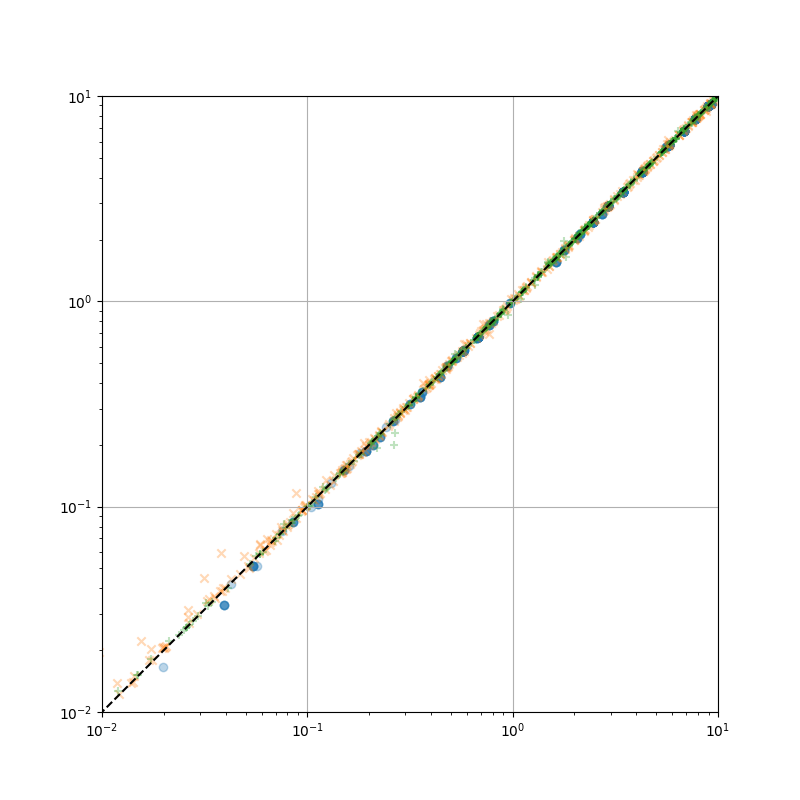

Text(0.5, 1.0, 'Comparison of pySLAMMER and SLAMMER results')

In [63]:
# df.plot.scatter(x="Rigid Normal (cm)", y="rigid_pysl", c="blue", label="Rigid")
# df.plot.scatter(x="Decoupled Normal (cm)", y="decoupled_pysl", c="orange", label="Decoupled")
# df.plot.scatter(x="Coupled Normal (cm)", y="coupled_pysl", c="green", label="Coupled")
# df.plot.scatter(x="kmax (g)", y="k_max_out", c="green", label="Coupled")
# plt.xlabel("SLAMMER Normalized Displacement (cm)")
# plt.ylabel("pySLAMMER Normalized Displacement (cm)")
# plt.title("Comparison of SLAMMER and pySLAMMER Normalized Displacements")
# plt.legend()

plt.close("all")
fig, ax = plt.subplots()
fig.set_size_inches(8,8)
# for key, grp in df.groupby(["Earthquake"]):
    # ax.scatter(
    #     grp["Decoupled Normal (cm)"], grp["decoupled_pysl"], label=key[0], alpha=0.5
    # )

ax.plot([0, 1000], [0, 1000], color="black", linestyle="--")

dfp = df#[df["soil model"] != "liner elastic"]

ax.scatter(df["Rigid Normal (cm)"], df["rigid_pysl"], marker = "o",label="Rigid", alpha=0.3)
ax.scatter(
    dfp["Decoupled Normal (cm)"],
    dfp["decoupled_pysl"],
    marker="x",
    label="Decoupled",
    alpha=0.3,
)
ax.scatter(
    dfp["Coupled Normal (cm)"],
    dfp["coupled_pysl"],
    marker="+",
    label="Coupled",
    alpha=0.3,
)



ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(10e-3, 1e1)
ax.set_ylim(10e-3, 1e1)
# ax.set_xlim(0, 100)
# ax.set_ylim(0, 100)

ax.set_aspect('equal', adjustable='box')

plt.grid()
plt.show()
# plt.legend(loc='upper right', bbox_to_anchor=(0.2, 1))
plt.legend()

plt.xlabel("SLAMMER displacement (cm)")
plt.ylabel("pySLAMMER displacement (cm)")
plt.title("Comparison of pySLAMMER and SLAMMER results")